In [36]:
import os
import numpy as np
from PIL import Image
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import zipfile

In [20]:
# Image size for resizing
IMG_SIZE = (64, 64)

In [2]:
# Function to extract ZIP files
def extract_zip(zip_file, extract_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_file} to {extract_path}")

In [65]:
# Function to extract simple features (average RGB) from an image
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    img = cv2.resize(img, IMG_SIZE)
    avg_rgb = np.mean(img, axis=(0, 1))
    return avg_rgb, img  # Return both features and resized image for EDA

In [66]:
# Load dataset and extract features with EDA
def load_data(indoor_path, outdoor_path):
    X, y, images = [], [], []
    for img_name in os.listdir(indoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(indoor_path, img_name))
            if features is not None and img is not None:
                X.append(features)
                y.append(0)
                images.append(img)
    for img_name in os.listdir(outdoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(outdoor_path, img_name))
            if features is not None and img is not None:
                X.append(features)
                y.append(1)
                images.append(img)
    return np.array(X), np.array(y), np.array(images)

In [72]:
# Perform EDA
def perform_eda(X, y, images):
    # Class distribution
    classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(["Indoor", "Outdoor"], counts, color=['blue', 'green'])
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.savefig("class_distribution.png")
    plt.show()

    # Image dimensions (before resizing)
    original_dims = []
    for img_path in [os.path.join("/content/Training", "museum-indoor", f) for f in os.listdir("/content/Training/museum-indoor")[:5]] + \
                    [os.path.join("/content/Training", "museum-outdoor", f) for f in os.listdir("/content/Training/museum-outdoor")[:5]]:
        with Image.open(img_path) as img:
            original_dims.append(img.size)
    original_dims = np.array(original_dims)
    print(f"Original Image Dimensions (sample of 10): Mean Width={np.mean(original_dims[:, 0]):.1f}, Mean Height={np.mean(original_dims[:, 1]):.1f}")
    print(f"Original Image Dimensions Std: Width={np.std(original_dims[:, 0]):.1f}, Height={np.std(original_dims[:, 1]):.1f}")

    # RGB Statistics
    rgb_values = np.array([x for x in X])
    rgb_mean = np.mean(rgb_values, axis=0)
    rgb_std = np.std(rgb_values, axis=0)
    print(f"Mean RGB Values: R={rgb_mean[0]:.1f}, G={rgb_mean[1]:.1f}, B={rgb_mean[2]:.1f}")
    print(f"Std of RGB Values: R={rgb_std[0]:.1f}, G={rgb_std[1]:.1f}, B={rgb_std[2]:.1f}")

    # Sample Images
    plt.figure(figsize=(12, 4))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {['Indoor', 'Outdoor'][y[i]]}")
        plt.axis('off')
    plt.savefig("sample_images.png")
    plt.show()

In [59]:
# Extended evaluation function with additional metrics
def evaluate_model(y_true, y_pred, y_prob, model_name):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        "Matthews CC": matthews_corrcoef(y_true, y_pred)
    }
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")
    return metrics

In [60]:
# Plot ROC curve
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot Precision-Recall curve
def plot_pr_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

# Bar chart for metric comparison
def plot_metric_comparison(metrics_dict):
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())
    data = np.array([[metrics_dict[model][metric] for metric in metrics] for model in models])

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.15
    index = np.arange(len(models))

    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, data[:, i], bar_width, label=metric)

    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Performance Metrics Comparison Across Models")
    plt.xticks(index + bar_width * (len(metrics) - 1) / 2, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("metric_comparison.png")
    plt.show()  # Display in Colab
    plt.close()

# Confusion Matrix Heatmap
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"cm_{model_name.lower().replace(' ', '_')}.png")
    plt.show()  # Display in Colab
    plt.close()

# Feature Importance (for Random Forest)
def plot_feature_importance(rf_model):
    features = ["Red Avg", "Green Avg", "Blue Avg"]
    importances = rf_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar(features, importances, color="skyblue")
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.savefig("feature_importance_rf.png")
    plt.show()  # Display in Colab
    plt.close()

# Learning Curve (for Random Forest)
def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy",
        shuffle=True, random_state=42)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training Accuracy")
    plt.plot(train_sizes, val_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig(f"learning_curve_{model_name.lower().replace(' ', '_')}.png")
    plt.show()  # Display in Colab
    plt.close()

In [68]:
# Main script
def phase_1():
    # Define paths to pre-uploaded ZIP files in Colab
    training_zip = "/content/Museum_Training.zip"
    test_zip = "/content/Museum_Test.zip"

    # Check if ZIP files exist
    if not os.path.exists(training_zip) or not os.path.exists(test_zip):
        print("Error: One or both ZIP files not found in /content/. Please ensure Museum_Training.zip and Museum_Test.zip are uploaded.")
        return

    # Extract ZIP files
    extract_path = "/content"
    extract_zip(training_zip, extract_path)
    extract_zip(test_zip, extract_path)

    # Define paths based on the structure
    train_indoor_path = os.path.join(extract_path, "Training", "museum-indoor")
    train_outdoor_path = os.path.join(extract_path, "Training", "museum-outdoor")
    test_indoor_path = os.path.join(extract_path, "Museum_Validation", "museum-indoor")
    test_outdoor_path = os.path.join(extract_path, "Museum_Validation", "museum-outdoor")

    # Verify paths exist
    for path in [train_indoor_path, train_outdoor_path, test_indoor_path, test_outdoor_path]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist. Check ZIP structure.")
            return

    # Load training data with images for EDA
    X_train_full, y_train_full, images = load_data(train_indoor_path, train_outdoor_path)
    print(f"Loaded {len(X_train_full)} training images.")
    if len(X_train_full) < 10:
        print("Error: Too few training images to proceed.")
        return

    # Perform EDA
    perform_eda(X_train_full, y_train_full, images)

    # Automated train/validation split (15% for validation)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42)

    # Dictionary to store metrics for all models
    all_metrics = {}
    all_cms = {}
    prob_dict = {}

    # 1. Supervised Decision Tree
    dt = DecisionTreeClassifier(max_depth=5, random_state=42)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_val)
    y_prob_dt = dt.predict_proba(X_val)[:, 1]
    all_metrics["Decision Tree"] = evaluate_model(y_val, y_pred_dt, y_prob_dt, "Decision Tree (Supervised)")

    # 2. Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    y_prob_rf = rf.predict_proba(X_val)[:, 1]
    all_metrics["Random Forest"] = evaluate_model(y_val, y_pred_rf, y_prob_rf, "Random Forest")

    # 3. Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    y_pred_gb = gb.predict(X_val)
    y_prob_gb = gb.predict_proba(X_val)[:, 1]
    all_metrics["Gradient Boosting"] = evaluate_model(y_val, y_pred_gb, y_prob_gb, "Gradient Boosting")

    # 4. Semi-Supervised Decision Tree
    X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42)
    for iteration in range(5):
        dt_semi = DecisionTreeClassifier(max_depth=5, random_state=42)
        dt_semi.fit(X_labeled, y_labeled)
        probs = dt_semi.predict_proba(X_unlabeled)
        y_pseudo = dt_semi.predict(X_unlabeled)
        confident_mask = (probs[:, 0] < 0.15) | (probs[:, 1] > 0.85)
        X_confident = X_unlabeled[confident_mask]
        y_confident = y_pseudo[confident_mask]
        X_labeled = np.vstack((X_labeled, X_confident))
        y_labeled = np.hstack((y_labeled, y_confident))
        X_unlabeled = X_unlabeled[~confident_mask]
        print(f"Iteration {iteration + 1}: Labeled samples = {len(y_labeled)}")

    y_pred_semi = dt_semi.predict(X_val)
    y_prob_semi = dt_semi.predict_proba(X_val)[:, 1]
    all_metrics["Semi-Supervised DT"] = evaluate_model(y_val, y_pred_semi, y_prob_semi, "Decision Tree (Semi-Supervised)")
    # Existing Plots
    plt.figure(figsize=(10, 6))
    plot_roc_curve(y_val, y_prob_dt, "Decision Tree")
    plot_roc_curve(y_val, y_prob_rf, "Random Forest")
    plot_roc_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_roc_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set)")
    plt.legend()
    plt.savefig("roc_curves.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pr_curve(y_val, y_prob_dt, "Decision Tree")
    plot_pr_curve(y_val, y_prob_rf, "Random Forest")
    plot_pr_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_pr_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Validation Set)")
    plt.legend()
    plt.savefig("pr_curves.png")
    plt.show()

    plot_metric_comparison(all_metrics)

    # New Plots
    # 1. Confusion Matrix Heatmaps for each model
    for model_name, cm in all_cms.items():
        plot_confusion_matrix(cm, model_name)

    # 2. Feature Importance for Random Forest
    plot_feature_importance(rf)

    # 3. Learning Curve for Random Forest (more stable than Gradient Boosting)
    plot_learning_curve(rf, X_train_full, y_train_full, "Random Forest")

    # Save models for demo
    joblib.dump(dt, "dt_model.pkl")
    joblib.dump(rf, "rf_model.pkl")
    joblib.dump(gb, "gb_model.pkl")
    joblib.dump(dt_semi, "dt_semi_model.pkl")

Extracted /content/Museum_Training.zip to /content
Extracted /content/Museum_Test.zip to /content
Loaded 10000 training images.


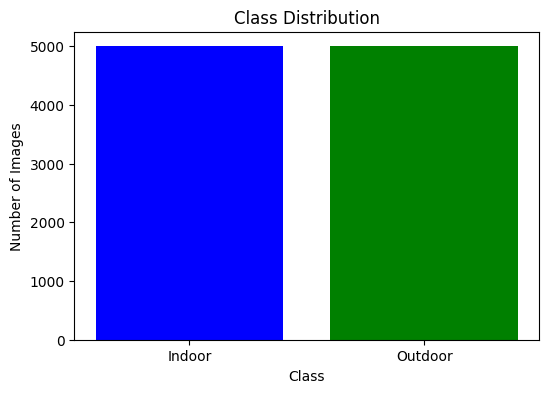

Original Image Dimensions (sample of 10): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values: R=108.5, G=115.9, B=121.3
Std of RGB Values: R=35.9, G=30.0, B=29.8


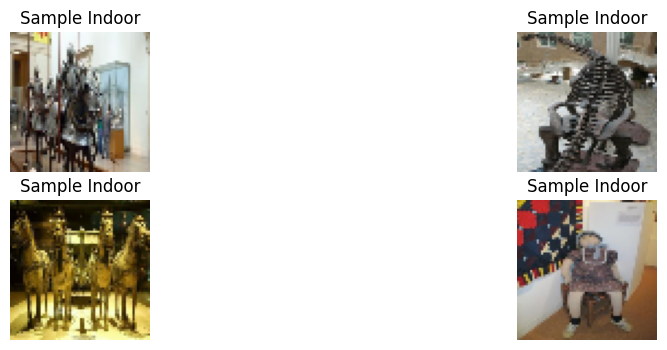


Decision Tree (Supervised) Performance:
Accuracy: 0.7820
Precision: 0.7640
Recall: 0.8102
F1-Score: 0.7864
ROC-AUC: 0.8557
Cohen's Kappa: 0.5642
Matthews CC: 0.5652
Confusion Matrix:
[[571 186]
 [141 602]]

Random Forest Performance:
Accuracy: 0.7920
Precision: 0.7752
Recall: 0.8170
F1-Score: 0.7955
ROC-AUC: 0.8692
Cohen's Kappa: 0.5842
Matthews CC: 0.5850
Confusion Matrix:
[[581 176]
 [136 607]]

Gradient Boosting Performance:
Accuracy: 0.7907
Precision: 0.7705
Recall: 0.8223
F1-Score: 0.7956
ROC-AUC: 0.8718
Cohen's Kappa: 0.5816
Matthews CC: 0.5829
Confusion Matrix:
[[575 182]
 [132 611]]
Iteration 1: Labeled samples = 2905
Iteration 2: Labeled samples = 3082
Iteration 3: Labeled samples = 3219
Iteration 4: Labeled samples = 3273
Iteration 5: Labeled samples = 3275

Decision Tree (Semi-Supervised) Performance:
Accuracy: 0.7807
Precision: 0.7464
Recall: 0.8439
F1-Score: 0.7922
ROC-AUC: 0.8225
Cohen's Kappa: 0.5618
Matthews CC: 0.5666
Confusion Matrix:
[[544 213]
 [116 627]]


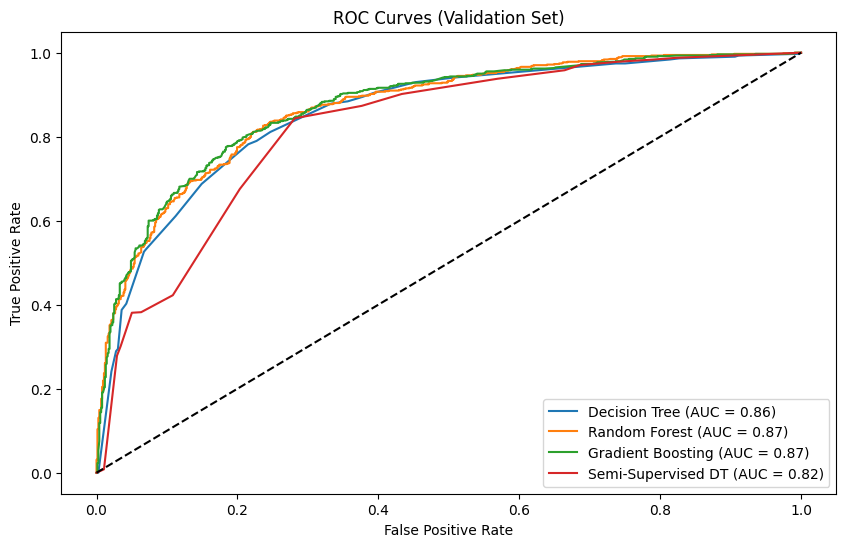

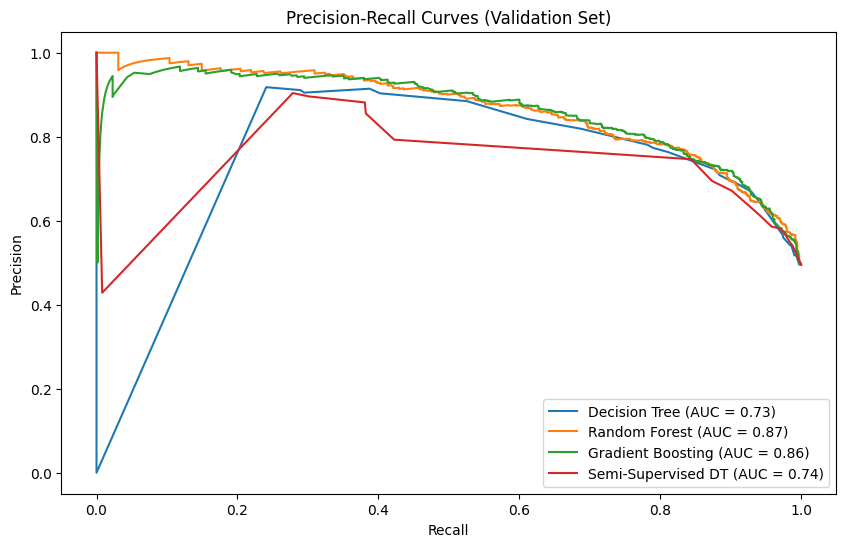

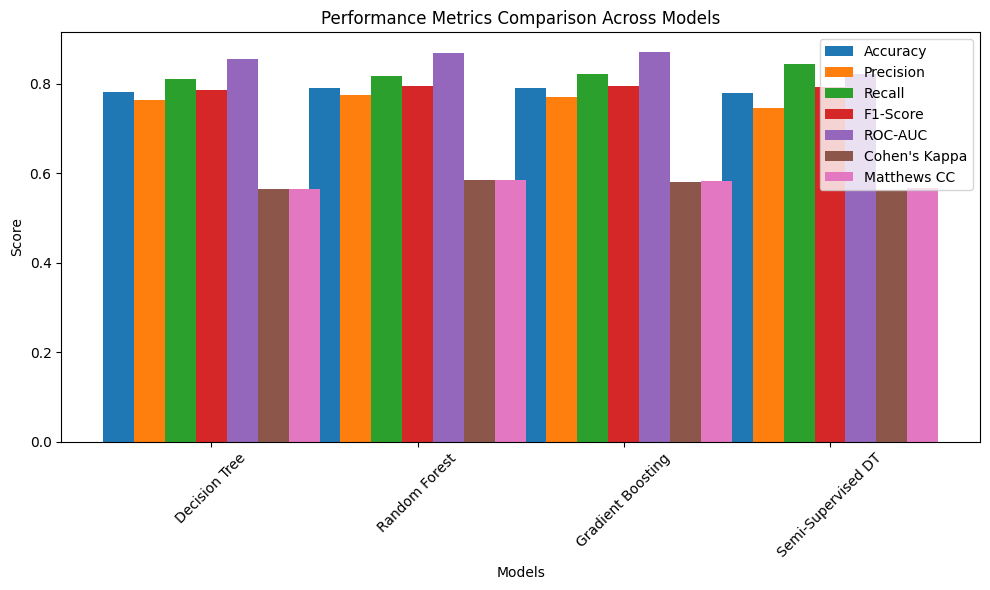

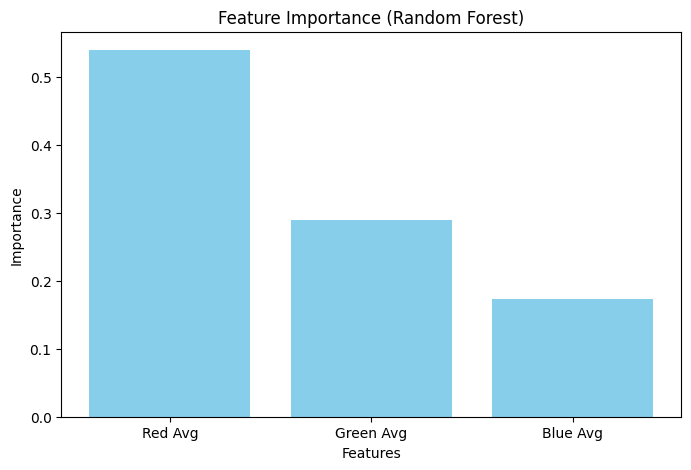

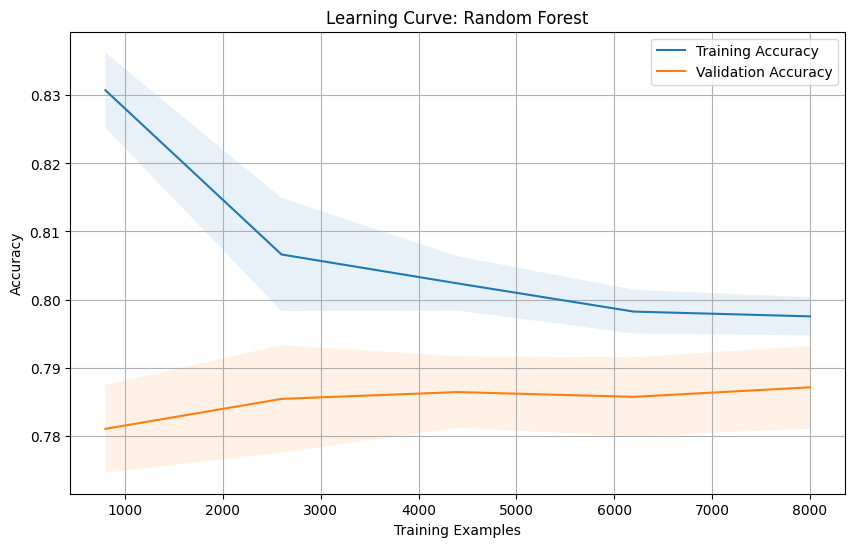

In [73]:
if __name__ == "__main__":
    phase_1()